In [1]:
# base
import os
import shutil
import random
import numpy as np
import time
from collections import Counter
from sklearn.metrics import mean_squared_error

# data preprocessing
import pandas as pd
pd.set_option('max_columns', 130, 'max_rows', 30)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ignore warining
import warnings
warnings.filterwarnings('ignore')


import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용


# save
from sklearn.externals import joblib 
import pickle

# selenium
#from selenium.webdriver import Chrome

import geopy.distance

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib 
import pickle

In [2]:
from geopy.distance import geodesic

import random
random.seed(42)

import lightgbm as lgb
from keras import metrics
from sklearn.metrics import r2_score

In [3]:
import matplotlib
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname = './data/bus/AppleGothic.ttf').get_name()
matplotlib.rc('font', family = font_name)

In [4]:
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
train = pd.read_csv("./data/bus/train.csv")
test = pd.read_csv("./data/bus/test.csv")
bts = pd.read_csv("./data/bus/bus_bts.csv")

train.shape, test.shape, bts.shape

((415423, 21), (228170, 20), (2409414, 13))

# 데이터 전처리

### 요일

In [6]:
train['date'] = pd.to_datetime(train['date'])
train['weekday'] = train['date'].dt.weekday

test['date'] = pd.to_datetime(test['date'])
test['weekday'] = test['date'].dt.weekday

train.shape, test.shape

((415423, 22), (228170, 21))

### route_station

route_station = bus_route_id + station_code

In [7]:
train['bus_route_id'] = train['bus_route_id'].astype(str)
train['station_code'] = train['station_code'].astype(str)
train['route_station'] = train['bus_route_id'] + ',' + train['station_code']

test['bus_route_id'] = test['bus_route_id'].astype(str)
test['station_code'] = test['station_code'].astype(str)
test['route_station'] = test['bus_route_id'] + ',' + test['station_code']

train.shape, test.shape

((415423, 23), (228170, 22))

### bus_route_id_weekday

bus_route_id_weekday = bus_route_id + weekday

In [8]:
train['bus_route_id_weekday'] = train['bus_route_id'].astype(str) + ',' + train['weekday'].astype(str) 
test['bus_route_id_weekday'] = test['bus_route_id'].astype(str) + ',' + test['weekday'].astype(str) 

train.shape, test.shape

((415423, 24), (228170, 23))

### station_code_weekday

station_code_weekday = station_code + weekday

In [9]:
train['station_code_weekday'] = train['station_code'].astype(str) + ',' + train['weekday'].astype(str)
test['station_code_weekday'] = test['station_code'].astype(str) + ',' + test['weekday'].astype(str)

train.shape, test.shape

((415423, 25), (228170, 24))

### route_station_weekday

route_station_weekday = route_station + weekay

In [10]:
train['route_station_weekday'] = train['route_station'].astype(str) + ',' + train['weekday'].astype(str) 
test['route_station_weekday'] = test['route_station'].astype(str) + ',' + test['weekday'].astype(str)

train.shape, test.shape

((415423, 26), (228170, 25))

### on_time

bts.csv 데이터에서 geton_time 열에서 시간대만 추출하여 on_time 컬럼을 만듬

In [11]:
bts['on_time']  = bts['geton_time'].apply(lambda x : x[:2])

bts.iloc[bts.query('on_time == "06"').index,13] = '6~7_ride'
bts.iloc[bts.query('on_time == "07"').index,13] = '7~8_ride'
bts.iloc[bts.query('on_time == "08"').index,13] = '8~9_ride'
bts.iloc[bts.query('on_time == "09"').index,13] = '9~10_ride'
bts.iloc[bts.query('on_time == "10"').index,13] = '10~11_ride'
bts.iloc[bts.query('on_time == "11"').index,13] = '11~12_ride'

bts.shape

(2409414, 14)

### 승 하차 시간대 통합 변수 (t ~ t+2)

t~t+1, t+1~t+2 시간대 승하차인원을 합하여 t~t+2 시간대 승하차인원 변수를 만듬

In [12]:
train['68a']=train['6~7_ride']+train['7~8_ride'] 
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] 
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

train.shape, test.shape

((415423, 32), (228170, 31))

# Make features by using target variable

우리가 최종적으로 예측해야할 것은 각 일자별(date), 버스 노선(bus_route_id) 상의 정류장(station_name)의 퇴근시간 하차인원(18~20_ride)임.

* bus_route_id, station_name, weekday의 각 조합별 퇴근시간 하차인원(18~20_ride)의 여러 통계량을 구한 후 이를 train set, test set에 모두 적용한다."
* target 변수를 train, test set에 적용할 수 있는 이유는 우리가 예측해야할 id는 date, bus_rout_id, station_name으로 구성되어있기 때문이다. 즉, 각각의 노선, 정류장별로 공통적인 패턴이 존재할 수 있다.
* 이 과정에서 NA 값이 생기는 이유는 train set에 없는 bus_route_id, station_name이 존재하기 때문.

In [13]:
def id_statistic(ID, col1, col2) :
    
    # mean, sum
    rs_mean = train.groupby([ID])['18~20_ride'].agg([(col1, 'mean')]).reset_index()
    rs_sum = train.groupby([ID])['18~20_ride'].agg([(col2, 'sum')]).reset_index()
    rs_mean_sum = pd.merge(rs_mean, rs_sum, on=ID)

    # merge
    tr = pd.merge(train, rs_mean_sum, how='left', on=ID)
    te = pd.merge(test, rs_mean_sum, how='left', on=ID)

    # na -&gt; mean
    te[col1] = te[col1].fillna(rs_mean.mean())
    te[col1] = te[col1].fillna(rs_sum.mean())
    
    return tr, te

In [14]:
train, test = id_statistic('route_station', '1820_rs_mean', '1820_rs_sum')

train.shape, test.shape

((415423, 34), (228170, 33))

In [15]:
train, test = id_statistic('bus_route_id', '1820_r_mean', '1820_r_sum')

train.shape, test.shape

((415423, 36), (228170, 35))

In [16]:
train, test = id_statistic('station_code', '1820_s_mean', '1820_s_sum')

train.shape, test.shape

((415423, 38), (228170, 37))

In [17]:
train, test = id_statistic('weekday', '1820_w_mean', '1820_w_sum')

train.shape, test.shape

((415423, 40), (228170, 39))

In [18]:
def mean_statistics() :

    f = train.groupby(['bus_route_id_weekday'])['18~20_ride'].agg([('mean_bus_weekday_ride','mean')]).reset_index()
    tr = pd.merge(train, f, how='left', on='bus_route_id_weekday')
    te = pd.merge(test, f, how='left', on='bus_route_id_weekday').fillna(f['mean_bus_weekday_ride'].mean())
    
    f = train.groupby(['station_code_weekday'])['18~20_ride'].agg([('mean_station_weekday_ride','mean')]).reset_index()
    tr = pd.merge(tr, f, how='left', on='station_code_weekday')
    te = pd.merge(te, f, how='left', on='station_code_weekday').fillna(f['mean_station_weekday_ride'].mean())
    
    f = train.groupby(['route_station_weekday'])['18~20_ride'].agg([('mean_route_station_weekday_ride','mean')]).reset_index()
    tr = pd.merge(tr, f, how='left', on='route_station_weekday')
    te = pd.merge(te, f, how='left', on='route_station_weekday').fillna(f['mean_route_station_weekday_ride'].mean())
    
    return tr, te

In [19]:
train, test = mean_statistics()

train.shape, test.shape

((415423, 43), (228170, 42))

### congestion

bus_route_id를 기준으로 18 ~ 20의 혼잡도를 계산.

In [20]:
def congestion() :
    df = train.groupby(['bus_route_id'])['18~20_ride'].agg([('passenger', 'sum')])
    df = df.sort_values(by='passenger', ascending=False).reset_index()
    
    def f(x):
        if x > 10000:
            return 7

        elif x > 5000:
            return 6

        elif x > 2000:
            return 5

        elif x > 700:
            return 4

        elif x > 200:
            return 3

        elif x > 50:
            return 2

        else:
            return 1
    
    df['congestion']=df['passenger'].apply(f)
    df = df[['bus_route_id','congestion']]
    
    tr = pd.merge(train, df, how='left', on='bus_route_id')
    te = pd.merge(test, df, how='left', on='bus_route_id')
    
    # 결측치는 데이터 프레임 df의 'congestion'의 중간값인 '4'으로 대체
    te = te.fillna(4)
    
    return tr, te

In [21]:
train, test = congestion()

train.shape, test.shape

((415423, 44), (228170, 43))

### location

location = latitude + longitude

In [22]:
train['location'] = train['latitude'].astype(str) + ',' + train['longitude'].astype(str)
test['location'] = test['latitude'].astype(str) + ',' + test['longitude'].astype(str)

train.shape, test.shape

((415423, 45), (228170, 44))

### merge key

In [23]:
# make cue column
train['cue']=0
test['cue']=1

train.shape, test.shape

((415423, 46), (228170, 45))

In [24]:
data = pd.concat([train, test])

In [25]:
data.head()

,1012a,1012b,10~11_ride,10~11_takeoff,11~12_ride,11~12_takeoff,1820_r_mean,1820_r_sum,1820_rs_mean,1820_rs_sum,1820_s_mean,1820_s_sum,1820_w_mean,1820_w_sum,18~20_ride,68a,68b,6~7_ride,6~7_takeoff,7~8_ride,7~8_takeoff,810a,810b,8~9_ride,8~9_takeoff,9~10_ride,9~10_takeoff,bus_route_id,bus_route_id_weekday,congestion,cue,date,id,in_out,latitude,location,longitude,mean_bus_weekday_ride,mean_route_station_weekday_ride,mean_station_weekday_ride,route_station,route_station_weekday,station_code,station_code_weekday,station_name,weekday
0,8.0,0.0,2.0,0.0,6.0,0.0,3.104381,2409.0,1.466667,44.0,1.466667,44.0,1.034282,54306.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,7.0,0.0,2.0,0.0,5.0,0.0,4270000,"4270000,6",5.0,0,2019-09-01,0,시외,33.48990,"33.4899,126.49373",126.49373,3.132812,0.2,0.200000,"4270000,344","4270000,344,6",344,"344,6",제주썬호텔,6
1,11.0,0.0,5.0,0.0,6.0,0.0,3.104381,2409.0,5.366667,161.0,4.178218,6330.0,1.034282,54306.0,5.0,5.0,0.0,1.0,0.0,4.0,0.0,6.0,0.0,4.0,0.0,2.0,0.0,4270000,"4270000,6",5.0,0,2019-09-01,1,시외,33.48944,"33.48944,126.48508",126.48508,3.132812,2.2,3.154867,"4270000,357","4270000,357,6",357,"357,6",한라병원,6
2,0.0,0.0,0.0,0.0,0.0,0.0,3.104381,2409.0,1.600000,48.0,2.169559,1625.0,1.034282,54306.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,4270000,"4270000,6",5.0,0,2019-09-01,2,시외,33.48181,"33.48181,126.47352",126.47352,3.132812,0.8,1.163462,"4270000,432","4270000,432,6",432,"432,6",정존마을,6
3,30.0,0.0,14.0,0.0,16.0,0.0,3.104381,2409.0,53.766667,1613.0,52.032258,1613.0,1.034282,54306.0,53.0,17.0,0.0,0.0,0.0,17.0,0.0,32.0,0.0,6.0,0.0,26.0,0.0,4270000,"4270000,6",5.0,0,2019-09-01,3,시내,33.50577,"33.50577,126.49252",126.49252,3.132812,56.0,56.000000,"4270000,1579","4270000,1579,6",1579,"1579,6",제주국제공항(600번),6
4,0.0,0.0,0.0,0.0,0.0,0.0,3.104381,2409.0,0.153846,4.0,0.732794,181.0,1.034282,54306.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4270000,"4270000,6",5.0,0,2019-09-01,4,시내,33.25579,"33.255790000000005,126.4126",126.41260,3.132812,0.4,1.108108,"4270000,1646","4270000,1646,6",1646,"1646,6",중문관광단지입구,6


### Label encoding feature

bus_route_id, station_name, route_station_weekday(bus_route_id + weekday의 조합), route_station(bus_route_id + station_code 의 조합) 총 4개를 라벨인코딩 해줌

In [26]:
labelencoder = LabelEncoder()
df_encode = data[['bus_route_id','station_code', 'route_station_weekday', 'route_station']]
df_encoded = df_encode.apply(labelencoder.fit_transform)

data['bus_route_id2']=df_encoded['bus_route_id']
data['station_code2']=df_encoded['station_code']
data['route_station_weekday2']=df_encoded['route_station_weekday']
data['route_station2']=df_encoded['route_station']

data.shape

(643593, 50)

### weekday (data)

In [27]:
data['date'] = pd.to_datetime(data['date'])
data['weekday'] = data['date'].dt.weekday
data = pd.get_dummies(data,columns=['weekday'])
data['weekday'] = data['date'].dt.weekday
data.shape

(643593, 57)

### in - out

In [28]:
data['in_out'].value_counts()
data['in_out'] = data['in_out'].map({'시내':0,'시외':1})

data.shape

(643593, 57)

### 출근 시간의 총 승객 수

In [29]:
data['ride_sum'] = data['6~7_ride'] + data['7~8_ride'] + data['8~9_ride'] + data['9~10_ride'] + data['10~11_ride'] + data['11~12_ride'] 
data['takeoff_sum'] = data['6~7_takeoff'] + data['7~8_takeoff'] + data['8~9_takeoff'] + data['9~10_takeoff'] + data['10~11_takeoff'] + data['11~12_takeoff'] 

data.shape

(643593, 59)

### 날짜 및 시간대 별 총 승객수

In [30]:
f = data.groupby('date')['6~7_ride'].agg([('6~7_all_ride_number', 'sum')]).reset_index()
data = pd.merge(data, f, how='left')

f = data.groupby('date')['7~8_ride'].agg([('7~8_all_ride_number', 'sum')]).reset_index()
data = pd.merge(data, f, how='left')

f = data.groupby('date')['8~9_ride'].agg([('8~9_all_ride_number', 'sum')]).reset_index()
data = pd.merge(data, f, how='left')

f = data.groupby('date')['9~10_ride'].agg([('9~10_all_ride_number', 'sum')]).reset_index()
data = pd.merge(data, f, how='left')

f = data.groupby('date')['10~11_ride'].agg([('10~11_all_ride_number', 'sum')]).reset_index()
data = pd.merge(data, f, how='left')

data.shape

(643593, 64)

### 주말, 주중

In [31]:
def h(x):
    if x ==5:
        return 1
    elif x==6:
        return 1
    else:
        return 0

In [32]:
data['weekend'] = data['weekday'].apply(h)

data.shape

(643593, 65)

### 연휴

In [33]:
def g(x):
    if x in ['2019-09-12','2019-09-13','2019-09-14','2019-10-03','2019-10-09']:
        return 1
    else:
        return 0

In [34]:
data['holiday'] = data['date'].apply(g) 

data.shape

(643593, 66)

### 요일 별 평균 승객 수

In [35]:
def week_mean() :

    df = data.reset_index(drop=True)
    df.groupby('weekday')['18~20_ride'].mean()
    df['weekdaymean']= 1

    index0 = df.query('weekday==0').index
    index1 = df.query('weekday==1').index
    index2 = df.query('weekday==2').index
    index3 = df.query('weekday==3').index
    index4 = df.query('weekday==4').index
    index5 = df.query('weekday==5').index
    index6 = df.query('weekday==6').index

    df.iloc[index0,-1] = 1.343710
    df.iloc[index1,-1] = 1.375319
    df.iloc[index2,-1] = 1.430856
    df.iloc[index3,-1] = 1.256710
    df.iloc[index4,-1] = 1.067439
    df.iloc[index5,-1] = 1.062123
    df.iloc[index6,-1] = 1.034282

    return df

In [36]:
data = week_mean()

data.shape

(643593, 67)

### 시내 및 시외버스 별 평균 탑승 승객

In [37]:
data['in_out_mean'] = 1
inindex = data.query('in_out == "시내"').index
outindex = data.query('in_out == "시외"').index

data.iloc[inindex,-1] = 1.228499
data.iloc[outindex,-1] = 2.044345
data['congestion'] = data['congestion'].astype('int64')

data.shape

(643593, 68)

### 카테고리별 승객 수

In [38]:
def category_people() :
    bts['bus_route_id'] = bts['bus_route_id'].astype(str)

    f = bts.groupby(['bus_route_id','user_category'])['user_count'].agg([('승객수', 'sum')]).reset_index()

    g = pd.pivot_table(f, values='승객수', index='bus_route_id', columns='user_category',fill_value=0).reset_index()
    g.columns = ['bus_route_id', 'adult','kids','teen','elder','jang','jang2','ugong','ugong2']
    g = g[['bus_route_id', 'adult','kids','teen','elder']]

    # merge
    df = pd.merge(data, g, how='left', on='bus_route_id')

    # na preprocessing -&gt; mean value
    df['adult'] = df['adult'].fillna(2363.077778)
    df['kids'] = df['kids'].fillna(60.426984)
    df['teen'] = df['teen'].fillna(448.277778)
    df['elder'] = df['elder'].fillna(751.309524)
                 
    return df

In [39]:
data['bus_route_id'] = data['bus_route_id'].astype(str)

In [40]:
data = category_people()

data.shape

(643593, 72)

### 카테고리 별 승객의 비율

In [41]:
def category_people_ratio() :
    
    a = bts.groupby('bus_route_id')['user_count'].agg([('전체', 'sum')]).reset_index()
    b = bts.groupby(['bus_route_id','user_category'])['user_count'].agg([('승객수', 'sum')]).reset_index()

    c = pd.merge(b, a, on='bus_route_id')
    c['비율'] = c['승객수']/c['전체']
    c = pd.pivot_table(c, values='비율', index='bus_route_id', columns='user_category',fill_value=0).reset_index()
    c.columns = ['bus_route_id', 'adult_prop','kids_prop','teen_prop','elder_prop','jang_prop','jang2_prop','ugong_prop','ugong2_prop']
    f = c[['bus_route_id', 'adult_prop','kids_prop','teen_prop','elder_prop']]

    df = pd.merge(data, f, how='left', on='bus_route_id')

    # na preprocessing -&gt; mean value
    df['adult_prop'] = df['adult_prop'].fillna(0.549702)
    df['kids_prop'] = df['kids_prop'].fillna(60.426984)
    df['teen_prop'] = df['teen_prop'].fillna(0.019902)
    df['elder_prop'] = df['elder_prop'].fillna(0.235848)

    return df

In [42]:
data = category_people_ratio()

data.shape

(643593, 76)

### 수요가 많을 것으로 예상되는 정류장

In [43]:
g = data[data['station_name'].str.contains('고등학교')]
highschool = list(g['station_name'].unique())

g = data[data['station_name'].str.contains('대학교')]
university = list(g['station_name'].unique())

In [44]:
def f(x):
    if x in highschool:
        return 1
    elif x in university:
        return 1
    else:
        return 0

In [45]:
data['school'] = data['station_name'].apply(f) 

In [46]:
g = data[data['station_name'].str.contains('환승')]
transfer = list(g['station_name'].unique())

g = data[data['station_name'].str.contains('공항')]
airport = list(g['station_name'].unique())

g = data[data['station_name'].str.contains('터미널')]
terminal = list(g['station_name'].unique())

In [47]:
def f(x):
    if x in transfer:
        return 1
    elif x in airport:
        return 1
    elif x in terminal:
        return 1
    else:
        return 0

In [48]:
data['transfer'] = data['station_name'].apply(f) 

data.shape

(643593, 78)

### 측정소와 정류장 사이 거리 계산

In [49]:
def dist() :
    jeju=(33.51411, 126.52969) # 제주 측정소 근처
    gosan=(33.29382, 126.16283) #고산 측정소 근처
    seongsan=(33.38677, 126.8802) #성산 측정소 근처
    po=(33.24616, 126.5653) #서귀포 측정소 근처

    t1 = [geopy.distance.geodesic( (i,j), jeju).km for i,j in list( zip( data['latitude'],data['longitude'] )) ]
    t2 = [geopy.distance.geodesic( (i,j), gosan).km for i,j in list( zip( data['latitude'],data['longitude'] )) ]
    t3 = [geopy.distance.geodesic( (i,j), seongsan).km for i,j in list( zip( data['latitude'],data['longitude'] )) ]
    t4 = [geopy.distance.geodesic( (i,j), po).km for i,j in list( zip( data['latitude'],data['longitude'] )) ]

    data['dis_jeju'] = t1
    data['dis_gosan']=t2
    data['dis_seongsan']=t3
    data['dis_po']=t4

    total = pd.DataFrame(list(zip(t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'])
    data['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)
    
    return data

In [50]:
data = dist()

data.shape

(643593, 83)

In [51]:
# dist_name 변수 생성된것 확인
data.head()

,1012a,1012b,10~11_ride,10~11_takeoff,11~12_ride,11~12_takeoff,1820_r_mean,1820_r_sum,1820_rs_mean,1820_rs_sum,1820_s_mean,1820_s_sum,1820_w_mean,1820_w_sum,18~20_ride,68a,68b,6~7_ride,6~7_takeoff,7~8_ride,7~8_takeoff,810a,810b,8~9_ride,8~9_takeoff,9~10_ride,9~10_takeoff,bus_route_id,bus_route_id_weekday,congestion,cue,date,id,in_out,latitude,location,longitude,mean_bus_weekday_ride,mean_route_station_weekday_ride,mean_station_weekday_ride,route_station,route_station_weekday,station_code,station_code_weekday,station_name,bus_route_id2,station_code2,route_station_weekday2,route_station2,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday,ride_sum,takeoff_sum,6~7_all_ride_number,7~8_all_ride_number,8~9_all_ride_number,9~10_all_ride_number,10~11_all_ride_number,weekend,holiday,weekdaymean,in_out_mean,adult,kids,teen,elder,adult_prop,kids_prop,teen_prop,elder_prop,school,transfer,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name
0,8.0,0.0,2.0,0.0,6.0,0.0,3.104381,2409.0,1.466667,44.0,1.466667,44.0,1.034282,54306.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,7.0,0.0,2.0,0.0,5.0,0.0,4270000,"4270000,6",5,0,2019-09-01,0,1,33.48990,"33.4899,126.49373",126.49373,3.132812,0.2,0.200000,"4270000,344","4270000,344,6",344,"344,6",제주썬호텔,625,2499,161004,31053,0,0,0,0,0,0,1,6,16.0,0.0,2942.0,4518.0,5682.0,6275.0,6774.0,1,0,1.034282,1.0,8158.0,72.0,38.0,0.0,0.986696,0.008708,0.004596,0.0,0,0,4.286659,37.692766,37.713630,27.841879,jeju
1,11.0,0.0,5.0,0.0,6.0,0.0,3.104381,2409.0,5.366667,161.0,4.178218,6330.0,1.034282,54306.0,5.0,5.0,0.0,1.0,0.0,4.0,0.0,6.0,0.0,4.0,0.0,2.0,0.0,4270000,"4270000,6",5,0,2019-09-01,1,1,33.48944,"33.48944,126.48508",126.48508,3.132812,2.2,3.154867,"4270000,357","4270000,357,6",357,"357,6",한라병원,625,2618,161011,31054,0,0,0,0,0,0,1,6,22.0,0.0,2942.0,4518.0,5682.0,6275.0,6774.0,1,0,1.034282,1.0,8158.0,72.0,38.0,0.0,0.986696,0.008708,0.004596,0.0,0,0,4.966848,37.008492,38.465822,27.996179,jeju
2,0.0,0.0,0.0,0.0,0.0,0.0,3.104381,2409.0,1.600000,48.0,2.169559,1625.0,1.034282,54306.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,4270000,"4270000,6",5,0,2019-09-01,2,1,33.48181,"33.48181,126.47352",126.47352,3.132812,0.8,1.163462,"4270000,432","4270000,432,6",432,"432,6",정존마을,625,2976,161026,31057,0,0,0,0,0,0,1,6,4.0,0.0,2942.0,4518.0,5682.0,6275.0,6774.0,1,0,1.034282,1.0,8158.0,72.0,38.0,0.0,0.986696,0.008708,0.004596,0.0,0,0,6.330746,35.642126,39.259820,27.496551,jeju
3,30.0,0.0,14.0,0.0,16.0,0.0,3.104381,2409.0,53.766667,1613.0,52.032258,1613.0,1.034282,54306.0,53.0,17.0,0.0,0.0,0.0,17.0,0.0,32.0,0.0,6.0,0.0,26.0,0.0,4270000,"4270000,6",5,0,2019-09-01,3,0,33.50577,"33.50577,126.49252",126.49252,3.132812,56.0,56.000000,"4270000,1579","4270000,1579,6",1579,"1579,6",제주국제공항(600번),625,587,160799,31020,0,0,0,0,0,0,1,6,79.0,0.0,2942.0,4518.0,5682.0,6275.0,6774.0,1,0,1.034282,1.0,8158.0,72.0,38.0,0.0,0.986696,0.008708,0.004596,0.0,0,1,3.575272,38.643401,38.386802,29.579404,jeju
4,0.0,0.0,0.0,0.0,0.0,0.0,3.104381,2409.0,0.153846,4.0,0.732794,181.0,1.034282,54306.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4270000,"4270000,6",5,0,2019-09-01,4,0,33.25579,"33.255790000000005,126.4126",126.41260,3.132812,0.4,1.108108,"4270000,1646","4270000,1646,6",1646,"1646,6",중문관광단지입구,625,652,160813,31022,0,0,0,0,0,0,1,6,0.0,1.0,2942.0,4518.0,5682.0,6275.0,6774.0,1,0,1.034282,1.0,8158.0,72.0,38.0,0.0,0.986696,0.008708,0.004596,0.0,0,0,30.652098,23.648361,45.899140,14.269792,po


### 날씨 관련 변수

중급자코드를 참고하면 rain3.csv를 만들 수 있다.

In [52]:
# 이미 이 과정을 통해 rain3.csv를 생성했으니 이 과정은 다시 반복 안해도 됨.
"""
raining = pd.read_csv("./data/bus/weather.csv")

#외부데이터에서 나오는 지점명들을 변경
raining['지점'] = [ str(i) for i in raining['지점'] ]

raining['지점'] = ['jeju' if i=='184' else i for i in raining['지점'] ]  # 위도 : 33.51411 경도 : 126.52969
raining['지점'] = ['gosan' if i=='185' else i for i in raining['지점'] ]  # 위도 : 33.29382 경도 : 126.16283
raining['지점'] = ['seongsan' if i=='188' else i for i in raining['지점'] ]  # 위도 : 33.38677 경도 : 126.8802
raining['지점'] = ['po' if i=='189' else i for i in raining['지점'] ]  # 위도 : 33.24616 경도 : 126.5653

raining.head()

# data merge를 위하여, 일시와 시간대를 분리
raining['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in raining['일시']] 

raining['일시'] = [ i.split(' ')[0] for i in raining['일시'] ] 

# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용
rain2 = raining[ (raining['time']>12)  ]

# 해당 시간대의 평균 기온 및 강수량을 변수로 사용할 예정이기 때문에, groupby를 실행
rain3 = rain2.groupby(['지점','일시'])[['기온(°C)','강수량(mm)']].mean()

rain3.to_csv("./data/bus/rain3.csv")

rain3=pd.read_csv("./data/bus/rain3.csv")

# train, test의 변수명과 통일시키고, NaN의 값은 0.0000으로 변경
rain3 = rain3.rename(columns={"일시":"date","지점":"dist_name"})
rain3 = rain3.fillna(0.00000)
rain3['date'] = pd.to_datetime(rain3['date'])

rain3.shape
"""

'\nraining = pd.read_csv("./data/bus/weather.csv")\n\n#외부데이터에서 나오는 지점명들을 변경\nraining[\'지점\'] = [ str(i) for i in raining[\'지점\'] ]\n\nraining[\'지점\'] = [\'jeju\' if i==\'184\' else i for i in raining[\'지점\'] ]  # 위도 : 33.51411 경도 : 126.52969\nraining[\'지점\'] = [\'gosan\' if i==\'185\' else i for i in raining[\'지점\'] ]  # 위도 : 33.29382 경도 : 126.16283\nraining[\'지점\'] = [\'seongsan\' if i==\'188\' else i for i in raining[\'지점\'] ]  # 위도 : 33.38677 경도 : 126.8802\nraining[\'지점\'] = [\'po\' if i==\'189\' else i for i in raining[\'지점\'] ]  # 위도 : 33.24616 경도 : 126.5653\n\nraining.head()\n\n# data merge를 위하여, 일시와 시간대를 분리\nraining[\'time\'] = [ int( i.split(\' \')[1].split(\':\')[0] ) for i in raining[\'일시\']] \n\nraining[\'일시\'] = [ i.split(\' \')[0] for i in raining[\'일시\'] ] \n\n# 실제 측정 데이터이기 때문에, 12시 이전의 시간대만 사용\nrain2 = raining[ (raining[\'time\']>12)  ]\n\n# 해당 시간대의 평균 기온 및 강수량을 변수로 사용할 예정이기 때문에, groupby를 실행\nrain3 = rain2.groupby([\'지점\',\'일시\'])[[\'기온(°C)\',\'강수량(mm)\']].mean()\n\nrain

In [53]:
rain3=pd.read_csv("./data/bus/rain3.csv")

# train, test의 변수명과 통일시키고, NaN의 값은 0.0000으로 변경
rain3 = rain3.rename(columns={"일시":"date","지점":"dist_name"})
rain3 = rain3.fillna(0.00000)
rain3['date'] = pd.to_datetime(rain3['date'])

rain3.shape

(1, 4)

In [54]:
# 최종적으로 완성이 된 외부데이터와 현재 만들어진 train, test data에 각각 merge
data = pd.merge(data, rain3, how='left',on=['dist_name','date'])

# 외부데이터와 결합 이후에, 기존에 만들어 놓은, dist name 변수에 one hot encoding을 실행한다.
data = pd.get_dummies(data,columns=['dist_name'])
#data = pd.get_dummies(data,columns=['si'])

data.shape

(643593, 88)

### rainy_day

비 오는날=1, 비 안오는 날=0

In [55]:
def f(x):
    if x == 0:
        return 0
    else:
        return 1

In [56]:
data['rainy_day'] = data['강수량(mm)'].apply(f)

data.shape

(643593, 89)

### 승 하차 시간대 통합 변수 (t ~ t+3)

t~t+1, t+1~t+2, t+2~t+3 시간대 승하차인원을 합하여 t~t+3 시간대 승하차인원 변수를 만듬

In [57]:
data['69a'] = data['6~7_ride']+data['7~8_ride']+data['8~9_ride']
data['912a']=data['9~10_ride']+data['10~11_ride']+data['11~12_ride']

data['69b'] = data['6~7_takeoff']+data['7~8_takeoff']+data['8~9_takeoff']
data['912b'] = data['9~10_takeoff']+data['10~11_takeoff']+data['11~12_takeoff']

data.shape

(643593, 93)

## train, test 데이터 분리

train, test 데이터를 만들어준다.

In [58]:
"""
from sklearn.model_selection import train_test_split

# 타겟 변수만 제외한 변수 모음
info = data.drop('18~20_ride', axis=1).values

# target variable을 분리한 후 데이터를 저장한다
target = data[['18~20_ride']].values

x_train, x_valid, y_train, y_valid = train_test_split(info, target, test_size=0.4, stratify=target, random_state=0)

"""
"""
훈련용
x_train: data 값
y_train: target 값(Survived)
검증용
x_valid: data 값
y_valid: target 값(Survived)
"""

'\n훈련용\nx_train: data 값\ny_train: target 값(Survived)\n검증용\nx_valid: data 값\ny_valid: target 값(Survived)\n'

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643593 entries, 0 to 643592
Data columns (total 93 columns):
1012a                              643593 non-null float64
1012b                              643593 non-null float64
10~11_ride                         643593 non-null float64
10~11_takeoff                      643593 non-null float64
11~12_ride                         643593 non-null float64
11~12_takeoff                      643593 non-null float64
1820_r_mean                        643593 non-null float64
1820_r_sum                         643593 non-null float64
1820_rs_mean                       643593 non-null float64
1820_rs_sum                        643593 non-null float64
1820_s_mean                        643593 non-null float64
1820_s_sum                         643593 non-null float64
1820_w_mean                        643593 non-null float64
1820_w_sum                         643593 non-null float64
18~20_ride                         415423 non-null float64
68a 

In [70]:
train_data = data.query('cue=="0"').reset_index() # train
test_data = data.query('cue=="1"').reset_index() # test

train_data.shape, test_data.shape

((415423, 94), (228170, 94))

In [69]:
#train_data.drop('cue', axis=1)
#test_data.drop('cue', axis=1)

## Random Forest

In [80]:
# 변수1
input_var1=['in_out','latitude','longitude','6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride',
           '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 
           'weekend', 'holiday', 'ride_sum', 'takeoff_sum', '1820_rs_mean', '1820_r_mean', '1820_s_mean', 'congestion',
           'station_code2', 'bus_route_id2',
           '6~7_all_ride_number', '7~8_all_ride_number', '8~9_all_ride_number', '9~10_all_ride_number', '10~11_all_ride_number',
           '1820_w_mean','in_out_mean','weekdaymean','adult','kids','teen','elder','adult_prop', 'kids_prop', 'teen_prop', 'elder_prop',
           '68a', '810a', '1012a', '68b', '810b', '1012b',
           'school', 'transfer']

from sklearn.model_selection import train_test_split

info = train_data[input_var1] # target variable 제외한 다른 정보변수들
target = train_data['18~20_ride'] # target variable

# train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(info, target, test_size=0.3, shuffle=True, random_state=123)

# 여기서 계속 뜨던 오류 : scikit-learn error: The least populated class in y has only 1 member
# 오류 해결 : https://stackoverflow.com/questions/43179429/scikit-learn-error-the-least-populated-class-in-y-has-only-1-member
# stratify=target 구문을 지운후 돌렸더니 에러 안뜸.

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((290796, 56), (124627, 56), (290796,), (124627,))

In [81]:
# 변수1
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(x_train, y_train)
rf_pred = rf.predict(x_valid)
accuracy = accuracy_score(y_valid, rf_pred)
print('랜덤 포레스트 정확도: {0: .4f}' .format(accuracy))

랜덤 포레스트 정확도:  0.7094


In [82]:
# RandomForest의 하이퍼 파라미터 default 상태
model = RandomForestClassifier()
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [83]:
# GridSearchCV를 통한 랜덤포레스트의 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.7214


In [84]:
#위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정
rf_clf1 = RandomForestClassifier(n_estimators = 100, 
                                max_depth = 12,
                                min_samples_leaf = 18,
                                min_samples_split = 8,
                                random_state = 0,
                                n_jobs = -1)
rf_clf1.fit(x_train, y_train)
pred = rf_clf1.predict(x_valid)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_valid, pred)))

예측 정확도: 0.7198


최적 하이퍼 파라미터로 적용한 모델 예측도가 전보다 0.01 향상되었음. (큰 향상은 아님)

그럼 각 변수의 중요도 시각화를 통해 중요도를 비교한 후 그 중 중요도 높은 변수만 따로 선택하여 랜덤포레스트를 돌려볼 예정.

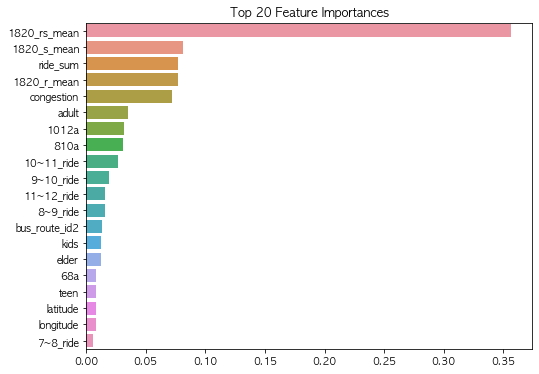

In [85]:
# 93개 변수 중에서 top 20개만 추출해보기
# Random Forest의 각 피처의 중요도 시각화 : featureimportances
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [86]:
# 피처의 중요도 시각화에서 나온 top 20개 변수로만 구성하여 새로운 input_var2 생성
# 변수2
input_var2=['1820_rs_mean','1820_s_mean','ride_sum','1820_r_mean','congestion','adult','1012a','810a','10~11_ride',
           '9~10_ride','11~12_ride','8~9_ride','bus_route_id2','kids','elder','68a','teen','latitude','longitude',
           '7~8_ride']

from sklearn.model_selection import train_test_split

info2 = train_data[input_var2] # target variable 제외한 다른 정보변수들
target = train_data['18~20_ride'] # target variable

# train_test_split
x2_train, x2_valid, y2_train, y2_valid = train_test_split(info2, target, test_size=0.3, shuffle=True, random_state=123)

# 여기서 계속 뜨던 오류 : scikit-learn error: The least populated class in y has only 1 member
# 오류 해결 : https://stackoverflow.com/questions/43179429/scikit-learn-error-the-least-populated-class-in-y-has-only-1-member
# stratify=target 구문을 지운후 돌렸더니 에러 안뜸.

x2_train.shape, x2_valid.shape, y2_train.shape, y2_valid.shape

((290796, 20), (124627, 20), (290796,), (124627,))

In [88]:
#위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정
rf_clf2 = RandomForestClassifier(n_estimators = 100, 
                                max_depth = 12,
                                min_samples_leaf = 18,
                                min_samples_split = 8,
                                random_state = 0,
                                n_jobs = -1)
rf_clf2.fit(x2_train, y2_train)
pred2 = rf_clf2.predict(x2_valid)
print('예측 정확도: {:.4f}'.format(accuracy_score(y2_valid, pred2)))

예측 정확도: 0.7195


rf_clf1 (0.7198) 보다 변수 20개로만 학습한 rf_clf2 (0.7195)의 예측도가 0.0003 떨어짐.

그냥 전처리 한 후 얻어진 모든 93개의 변수 모음으로 학습한 것이 조금 더 나은듯 함.

In [103]:
# 밑에 Linear Regression 결과로 얻어진 회귀계수도가 높은 변수들 모음

# 변수3
input_var3=['1820_rs_mean','1820_w_mean', 'school','adult_prop','weekdaymean','1012a',
            '11~12_ride', 'weekday_3','weekday_2','weekday_1']

from sklearn.model_selection import train_test_split

info3 = train_data[input_var3] # target variable 제외한 다른 정보변수들
target = train_data['18~20_ride'] # target variable

# train_test_split
x3_train, x3_valid, y3_train, y3_valid = train_test_split(info3, target, test_size=0.3, shuffle=True, random_state=123)

# 여기서 계속 뜨던 오류 : scikit-learn error: The least populated class in y has only 1 member
# 오류 해결 : https://stackoverflow.com/questions/43179429/scikit-learn-error-the-least-populated-class-in-y-has-only-1-member
# stratify=target 구문을 지운후 돌렸더니 에러 안뜸.

x3_train.shape, x3_valid.shape, y3_train.shape, y3_valid.shape

((290796, 10), (124627, 10), (290796,), (124627,))

In [105]:
#위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정
rf_clf3 = RandomForestClassifier(n_estimators = 100, 
                                max_depth = 12,
                                min_samples_leaf = 18,
                                min_samples_split = 8,
                                random_state = 0,
                                n_jobs = -1)
rf_clf3.fit(x3_train, y3_train)
pred3 = rf_clf3.predict(x3_valid)
print('예측 정확도: {:.4f}'.format(accuracy_score(y3_valid, pred3)))

예측 정확도: 0.7203


rf_clf3 으로 돌린 결과가 rf_clf1, rf_clf2 보다 더 예측 정확도가 높음.

우리의 변수는 input_var3로 가져가는 것이 좋을듯.

## LinearRegression

In [95]:
# 변수1
input_var1=['in_out','latitude','longitude','6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride',
           '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 
           'weekend', 'holiday', 'ride_sum', 'takeoff_sum', '1820_rs_mean', '1820_r_mean', '1820_s_mean', 'congestion',
           'station_code2', 'bus_route_id2',
           '6~7_all_ride_number', '7~8_all_ride_number', '8~9_all_ride_number', '9~10_all_ride_number', '10~11_all_ride_number',
           '1820_w_mean','in_out_mean','weekdaymean','adult','kids','teen','elder','adult_prop', 'kids_prop', 'teen_prop', 'elder_prop',
           '68a', '810a', '1012a', '68b', '810b', '1012b',
           'school', 'transfer']

from sklearn.model_selection import train_test_split

info = train_data[input_var1] # target variable 제외한 다른 정보변수들
target = train_data['18~20_ride'] # target variable

# train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(info, target, test_size=0.3, shuffle=True, random_state=123)

# 여기서 계속 뜨던 오류 : scikit-learn error: The least populated class in y has only 1 member
# 오류 해결 : https://stackoverflow.com/questions/43179429/scikit-learn-error-the-least-populated-class-in-y-has-only-1-member
# stratify=target 구문을 지운후 돌렸더니 에러 안뜸.

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((290796, 56), (124627, 56), (290796,), (124627,))

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 선형 회귀 OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(x_train, y_train)

y_preds = lr.predict(x_valid)
mse = mean_squared_error(y_valid, y_preds)
rmse = np.sqrt(mse)
print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_valid, y_preds)))

MSE : 5.695, RMSE : 2.386
Variance score : 0.738


In [100]:
print('절편 값:', lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 6.970634790404073
회귀 계수값: [-0.1 -0.1 -0.  -0.  -0.   0.   0.  -0.   0.1  0.   0.   0.   0.  -0.
  0.  -0.1  0.1  0.1  0.1 -0.2  0.  -0.   0.   0.   0.   0.   0.9 -0.
  0.   0.  -0.   0.  -0.   0.  -0.  -0.   0.   0.1  0.   0.1 -0.  -0.
  0.   0.   0.1 -0.  -0.1  0.  -0.   0.   0.1  0.   0.  -0.   0.1 -0.2]


In [101]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=x_train.columns)
coeff.sort_values(ascending=False)

1820_rs_mean             0.9
weekday_3                0.1
weekday_2                0.1
weekday_1                0.1
school                   0.1
1820_w_mean              0.1
adult_prop               0.1
weekdaymean              0.1
1012a                    0.1
11~12_ride               0.1
weekend                  0.0
weekday_5                0.0
longitude               -0.0
holiday                  0.0
ride_sum                 0.0
                        ... 
in_out_mean              0.0
10~11_all_ride_number    0.0
9~10_all_ride_number    -0.0
8~9_all_ride_number     -0.0
7~8_all_ride_number      0.0
6~7_all_ride_number     -0.0
bus_route_id2            0.0
7~8_ride                -0.0
8~9_ride                 0.0
latitude                -0.1
in_out                  -0.1
weekday_0               -0.1
teen_prop               -0.1
weekday_4               -0.2
transfer                -0.2
Length: 56, dtype: float64

## LightGBM

In [92]:
# 변수1
input_var1=['in_out','latitude','longitude','6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride',
           '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 
           'weekend', 'holiday', 'ride_sum', 'takeoff_sum', '1820_rs_mean', '1820_r_mean', '1820_s_mean', 'congestion',
           'station_code2', 'bus_route_id2',
           '6~7_all_ride_number', '7~8_all_ride_number', '8~9_all_ride_number', '9~10_all_ride_number', '10~11_all_ride_number',
           '1820_w_mean','in_out_mean','weekdaymean','adult','kids','teen','elder','adult_prop', 'kids_prop', 'teen_prop', 'elder_prop',
           '68a', '810a', '1012a', '68b', '810b', '1012b',
           'school', 'transfer']

from sklearn.model_selection import train_test_split

info = train_data[input_var1] # target variable 제외한 다른 정보변수들
target = train_data['18~20_ride'] # target variable

# train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(info, target, test_size=0.3, shuffle=True, random_state=123)

# 여기서 계속 뜨던 오류 : scikit-learn error: The least populated class in y has only 1 member
# 오류 해결 : https://stackoverflow.com/questions/43179429/scikit-learn-error-the-least-populated-class-in-y-has-only-1-member
# stratify=target 구문을 지운후 돌렸더니 에러 안뜸.

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((290796, 56), (124627, 56), (290796,), (124627,))

In [94]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트 from lightgbm import LGBMClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

lgbm_wrapper = LGBMClassifier(n_estimators=400)

evals = [(x_valid, y_valid)]
lgbm_wrapper.fit(x_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(x_valid)
pred_proba = lgbm_wrapper.predict_proba(x_valid)[:, 1]

ValueError: y contains previously unseen labels: [90.0, 98.0, 113.0, 114.0, 131.0, 136.0, 143.0, 155.0, 167.0, 168.0, 170.0, 180.0, 185.0, 202.0, 229.0]

## XGBoost

In [106]:
# 변수3
input_var3=['1820_rs_mean','1820_w_mean', 'school','adult_prop','weekdaymean','1012a',
            '11~12_ride', 'weekday_3','weekday_2','weekday_1']

from sklearn.model_selection import train_test_split

info3 = train_data[input_var3] # target variable 제외한 다른 정보변수들
target = train_data['18~20_ride'] # target variable

# train_test_split
x3_train, x3_valid, y3_train, y3_valid = train_test_split(info3, target, test_size=0.3, shuffle=True, random_state=123)

# 여기서 계속 뜨던 오류 : scikit-learn error: The least populated class in y has only 1 member
# 오류 해결 : https://stackoverflow.com/questions/43179429/scikit-learn-error-the-least-populated-class-in-y-has-only-1-member
# stratify=target 구문을 지운후 돌렸더니 에러 안뜸.

x3_train.shape, x3_valid.shape, y3_train.shape, y3_valid.shape

((290796, 10), (124627, 10), (290796,), (124627,))

In [109]:
import xgboost as xgb
from xgboost import plot_importance

dtrain = xgb.DMatrix(data=x3_train, label=y3_train)
dtest = xgb.DMatrix(data=x3_valid, label=y3_valid)

params = { 'max_depth':3,
          'eta': 0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss', 
          'early_stoppings':100
}

num_rounds = 400

# train 데이터 세트는 'train*, evaluation(test) 데이터 세트는 ’eval'로 명기합니다.
wlist = [(dtrain, 'train'), (dtest, 'eval') ]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달 
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, \
early_stopping_rounds=100, evals=wlist )

pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:', preds[:10])

XGBoostError: [21:30:07] src/objective/regression_obj.cu:101: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000001b11192e19 dmlc::LogMessageFatal::~LogMessageFatal() + 57
  [bt] (1) 2   libxgboost.dylib                    0x0000001b11219c1d xgboost::obj::RegLossObj<xgboost::obj::LogisticClassification>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*) + 1133
  [bt] (2) 3   libxgboost.dylib                    0x0000001b1118ea9e xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*) + 1278
  [bt] (3) 4   libxgboost.dylib                    0x0000001b111af34c XGBoosterUpdateOneIter + 172
  [bt] (4) 5   libffi.6.dylib                      0x000000010320e884 ffi_call_unix64 + 76
  [bt] (5) 6   ???                                 0x00007ffeee90caa0 0x0 + 140732900887200



In [ ]:
get_clf_eval(y_test , preds, pred_probs)

In [ ]:
# xgboost의 plot_importance() API는 피처의 중요도를 막대그래프로 시각화
from xgboost import plot_importance

fig, ax = pit.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)